Create table for A/A tests

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json
import seaborn as sns
sns.set()
sns.set_context("paper")

In [19]:
app_bench_result_path = '../../../resultsVM/regressionApp'

load data and analyze differences between runs

In [20]:
latenciesTypes = ['latenciesInserts1Old', 'latenciesInserts1New',
                  'latenciesInserts2Old', 'latenciesInserts2New',
                  'latenciesQueries1Old', 'latenciesQueries1New',
                  'latenciesQueries2Old', 'latenciesQueries2New']


In [21]:
def loadLatencies(resultPath):
    latenciesDict = {}
    for latenciesType in latenciesTypes:
        # advisable to use os.path.join as this makes concatenation OS independent
        all_files = glob.glob(os.path.join(
            resultPath, "*", latenciesType + ".csv"))

        df_from_each_file = [pd.read_csv(f, delim_whitespace=True, index_col=0, names=[
                                         int(f.split('/')[-2])]) for f in all_files]
        df_from_each_file = df_from_each_file[::-1]
        df = pd.concat(df_from_each_file, axis=1, copy=True)

        df = df.sort_index(axis=1)
        latenciesDict[latenciesType] = df
    latenciesDict = preprocess_latencies(latenciesDict)

    return latenciesDict


def preprocess_latencies(latenciesDict):
    #Read latency file for both types (old and new)
    insertsOld1 = latenciesDict['latenciesInserts1Old']
    insertsOld2 = latenciesDict['latenciesInserts2Old']
    insertsOld = pd.concat([drop_rows(insertsOld1), drop_rows(insertsOld2)])
    latenciesDict['latenciesInsertsOld'] = insertsOld

    insertsNew1 =  latenciesDict['latenciesInserts1New']
    insertsNew2 = latenciesDict['latenciesInserts2New']
    insertsNew = pd.concat([drop_rows(insertsNew1), drop_rows(insertsNew2)])
    latenciesDict['latenciesInsertsNew'] = insertsNew


    queries1Old = latenciesDict['latenciesQueries1Old']

    queries1Old = drop_rows(queries1Old)
    

    queries2Old = latenciesDict['latenciesQueries2Old']


    queries2Old = drop_rows(queries2Old)

    queries1New = latenciesDict['latenciesQueries1New']
    
    queries1New = drop_rows(queries1New)


    queries2New = latenciesDict['latenciesQueries2New']

    queries2New = drop_rows(queries2New)

    return latenciesDict

def drop_rows(df: pd.DataFrame)->pd.DataFrame:
    num_to_drop_head = int(df.shape[0] * 0.05)
    num_to_drop_tail = int(df.shape[0] * 0.2)
    df = df.drop(df.tail(num_to_drop_tail).index)
    df = df.drop(df.head(num_to_drop_head).index)
    return df



In [22]:
def relative_speedup(med1, med2): return ((med2/med1)-1)*100

def get_relative_speedups(latencies):
    relative_speedups = {}
    med1=latencies['latenciesInsertsOld'].median(axis=0)
    med2=latencies['latenciesInsertsNew'].median(axis=0)

    med3=latencies['latenciesQueries1Old'].median(axis=0)
    med4=latencies['latenciesQueries1New'].median(axis=0)

    med5=latencies['latenciesQueries2Old'].median(axis=0)
    med6=latencies['latenciesQueries2New'].median(axis=0)
    
    
    relative_speedups['latenciesInserts'] = relative_speedup(med1,med2)
    relative_speedups['latenciesQueries1'] = relative_speedup(med3,med4)
    relative_speedups['latenciesQueries2'] = relative_speedup(med5,med6)
    
    return relative_speedups

def aggregate_latencies(runs: list) -> dict:
    aggregation = {}

    aggregate_on_key(runs, 'latenciesInserts', aggregation)
    aggregate_on_key(runs, 'latenciesQueries1', aggregation)
    aggregate_on_key(runs, 'latenciesQueries2', aggregation)
    
    return aggregation


    

def aggregate_on_key(runs: list, key: str, aggregation: dict) -> dict:
    data = []
    for run in runs:
        med1 = run[key + 'Old'].median()
        med2 = run[key + 'New'].median()
        data.append(relative_speedup(med1, med2))
    data = np.array(data)
    aggregation[key] = {}
    aggregation[key]['max'] = data.max(axis=0)
    aggregation[key]['min'] = data.min(axis=0)
    aggregation[key]['med'] = np.median(data, axis=0)

    return aggregation



In [23]:
def plotDistribution(df1, df2):
    
    
    fig, axs = plt.subplots(10, 2, figsize = (15, 30), sharey=True)
    plt.suptitle('Relative differences between A1 and A2')
    for counter, column in enumerate(df1.columns):
        # filter outlier with 90%-quantile
        q1 = np.min(df1[column])
        q3_old = np.percentile(df1[column],90)
        q3_new = np.percentile(df2[column],90)
        q3 = np.max([q3_old, q3_new])
        
        axs[counter, 0].hist(df1[column],range=(q1, q3), density=True, bins=50)
        axs[counter, 0].set_title('commit number ' + str(column))
        
        
        axs[counter, 1].hist(df2[column], range=(q1, q3), density=True, bins=50)
        axs[counter, 1].set_title('commit number ' + str(column))

def plot_boxes(relative_latencies):
    fig, axs = plt.subplots(1, 3, figsize = (15,4))
    
    sns.boxplot(y=relative_latencies['latenciesInserts'], ax=axs[0], showfliers=False).set(
        xlabel='Inserts', 
        ylabel='relative speedup, %'
    )

    sns.boxplot(y=relative_latencies['latenciesQueries1'], ax=axs[1], showfliers=False).set(
        xlabel='First set of queries', 
        ylabel='relative speedup, %'
    )
    
    sns.boxplot(y=relative_latencies['latenciesQueries2'], ax=axs[2], showfliers=False).set(
        xlabel='Second set of queries', 
        ylabel='relative speedup, %'
    )

def plotRegressions(aggregation: dict):
    
    # fig, axs = plt.subplots(1, 3, figsize = (15,4), sharey=True)
    axs_titles = ['Inserts', 'First set of queries', 'Second set of queries']
    for counter, key in enumerate(['latenciesInserts', 'latenciesQueries1', 'latenciesQueries2']):
        plt.plot(aggregation[key]['min'], 'b-')
        plt.plot(aggregation[key]['max'], 'b-')
        plt.plot(aggregation[key]['med'], 'r-')
        plt.axhline(0, color='black',linestyle="--")
        # plt.yaxis.set_tick_params(labelbottom=True)
        plt.xlabel('commit, number')
        plt.ylabel('relative speedup, %')
        plt.suptitle(axs_titles[counter])
        
        plt.savefig('app_regressions/' + key + ".png", bbox_inches="tight")
        plt.clf()



    

    
        

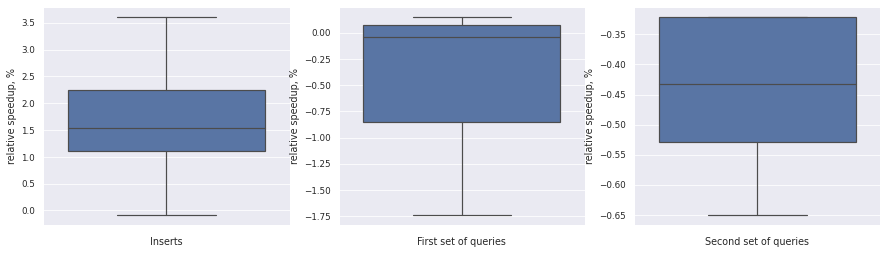

In [24]:
latencies=loadLatencies(os.path.join(app_bench_result_path, "runAA"))
relative_latencies = get_relative_speedups(latencies)
plot_boxes(relative_latencies)
plt.savefig('aa_tests_box_plots.png', bbox_inches="tight")

None

## Test Run for 5 random commits

In [25]:
runs = [loadLatencies(os.path.join(app_bench_result_path, run)) for run in ['run1', 'run2', 'run3']]

In [26]:
aggregation = aggregate_latencies(runs)

In [27]:
!mkdir -p app_regressions
plotRegressions(aggregation)

<Figure size 432x288 with 0 Axes>